IMPORTING LIBRARIES & PACKAGES

In [ ]:
import pandas as pd
import re

from bs4 import BeautifulSoup as bs
import requests
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

SCRAPING HOTEL REVIEWS

WEBSITE: https://www.booking.com/reviews/us/hotel/beresford

Empty lists are created to store reviewers' information and reviews.

A while loop is used to scrape multiple pages (up to 30 pages).

For each page, the script:


*   Retrieves the HTML content using requests.get().
*   Parses the HTML content using BeautifulSoup.
*   Extracts the review box containing all reviews.
*   Extracts various information from each review:

    1.   Ratings
    2.   Reviewer name, Country, Overall review
    3.   Review times
    4.   Review date
    5.   Reviewer tags

*   Appends all reviewers' information to the info list.


*   After scraping all pages, the script creates a Pandas DataFrame reviewer_info from the info list.
*   The DataFrame is cleaned and formatted:

    1.   Rating is converted to a numeric value.
    2.   Review times are extracted from the text and converted to a numeric value.
    3.   Review date is converted to a datetime object.

*   The function returns the reviewer_info DataFrame.


In [ ]:
def scrape_reviews():
    '''
    Function to scrape hotel reviews from bookings.com
    INPUTS:
        hotel_linkname - hotel name in the bookings.com weblink
        total_pages - the total number of reviews pages to scrape
    OUTPUTS:
        reviewer_info - a dataframe that includes reviewers' basic information
    '''
    #Create empty lists to put in reviewers' information as well as all of the positive & negative reviews
    info = []

    #bookings.com reviews link
    url = 'https://www.booking.com/reviews/us/hotel/beresford.en-gb.html?label=gen173nr-1FCA0o7AFCCWJlcmVzZm9yZEgzWARokQKIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4ArGo6_oFwAIB0gIkODFmNjUzODEtMWU5Ny00ZjIzLWI2MWEtYjBjZGU2NzI0ZWYz2AIF4AIB&sid=f67a1941a3d25cae5781e6642f694bbc&customer_type=total&hp_nav=0&keep_landing=1&order=featuredreviews&page=1&r_lang=en&rows=75&'
    page_number = 1

    #Use a while loop to scrape all the pages
    while page_number <= 30:

        page = requests.get(url + str(page_number)) #retrieve data from serve
        soup = bs(page.text, "html.parser") # initiate a beautifulsoup object using the html source and Python’s html.parser
        review_box = soup.find('ul',{'class':'review_list'})

        #ratings
        ratings = [i.text.strip() for i in review_box.find_all('span',{'class':'review-score-badge'})]

        #reviewer_info
        reviewer_info = [i.text.strip() for i in review_box.find_all('span',{'itemprop':'name'})]
        reviewer_name = reviewer_info[0::3]
        reviewer_country = reviewer_info[1::3]
        general_review = reviewer_info[2::3]

        # reviewer_review_times
        review_times = [i.text.strip() for i in review_box.find_all('div',{'class':'review_item_user_review_count'})]

        # review_date
        review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p',{'class':'review_item_date'})]

        # reviewer_tag
        reviewer_tag = [i.text.strip().replace('\n\n\n','').replace('•',',').lstrip(', ') for i
                        in review_box.find_all('ul',{'class':'review_item_info_tags'})]

        # append all reviewers' info into one list
        for i in range(len(reviewer_name)):
            info.append([ratings[i],reviewer_name[i],reviewer_country[i],general_review[i],
                         review_times[i],review_date[i],reviewer_tag[i]])

        # page change
        page_number +=1

    #Reviewer_info df
    reviewer_info = pd.DataFrame(info,
                        columns = ['Rating','Name','Country','Overall_review','Review_times','Review_date','Review_tags'])
    reviewer_info['Rating'] = pd.to_numeric(reviewer_info['Rating'] )
    reviewer_info['Review_times'] = pd.to_numeric(reviewer_info['Review_times'].apply(lambda x:re.findall("\d+", x)[0]))
    reviewer_info['Review_date'] = pd.to_datetime(reviewer_info['Review_date'])

    return reviewer_info

def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(reviewer_info.isnull().sum().sum()))
    return df.head(10)

In [ ]:
reviewer_info = scrape_reviews()

WEB-SCRAPED DATA-COLLECTED DATAFRAME

In [ ]:
#reviewers' basic information
show_data(reviewer_info)

The length of the dataframe is: 720
Total NAs: 0


,Rating,Name,Country,Overall_review,Review_times,Review_date,Review_tags
0,8.0,Edward,United States,Very good,1,2024-05-27,"Leisure trip, Family with young children, Twin..."
1,7.0,Everett,United States,Good,2,2024-05-26,"Leisure trip, People with friends, Double Room..."
2,7.0,Alauddin,Bangladesh,There was no heating system/ the existing heat...,9,2024-05-26,"Leisure trip, Group, Deluxe King Room, Stayed ..."
3,8.0,Eduardo,Mexico,Very good,5,2024-05-19,"Leisure trip, Couple, Queen Room, Stayed 3 nig..."
4,8.0,Michelle,United Kingdom,A lovely stay in the centre of San Francisco -...,24,2024-05-16,"Leisure trip, Solo traveller, Deluxe King Room..."
5,8.0,Paul,New Zealand,Very good,19,2024-05-14,"Business trip, Solo traveller, Queen Room, Sta..."
6,8.0,Alexandre,France,Very good,4,2024-05-10,"Leisure trip, Family with young children, Quee..."
7,8.0,Jan,New Zealand,"Comfortable stay, friendly staff. Very good va...",4,2024-05-01,"Leisure trip, Couple, Queen Room, Stayed 9 nights"
8,7.0,Darren,United States,Overall a good experience and front desk peopl...,2,2024-04-27,"Leisure trip, Couple, Queen Room, Stayed 2 nig..."
9,6.0,Jose,Spain,"If you get it cheap, it is a decent stay to vi...",23,2024-04-17,"Leisure trip, Couple, Queen Room, Stayed 9 nig..."


PRE-PROCESSING

*   Converts all text in the 'Overall_review' column to lowercase.
*   Removes all special characters and punctuation from the text, leaving only words and spaces.
*   Removes common English stopwords (like 'the', 'and', etc.) from the text.

In [ ]:
# Preprocessing
reviewer_info['Overall_review'] = reviewer_info['Overall_review'].str.lower()
reviewer_info['Overall_review'] = reviewer_info['Overall_review'].str.replace(r'[^\w\s]', '')
reviewer_info['Overall_review'] = reviewer_info['Overall_review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

DATA SPLITTING

Splits the data into training (80%) and testing sets (20%).

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_data, test_data = train_test_split(reviewer_info, test_size=0.2, random_state=42)

SENTIMENT ANALYSIS

In [ ]:
pip install vadersentiment

In [ ]:
# Import the VADER lexicon
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Labeling (assuming 1=positive, 0=neutral, -1=negative)
train_data['sentiment'] = train_data['Overall_review'].apply(lambda x:
    1 if sia.polarity_scores(x)['compound'] > 0.05
    else (-1 if sia.polarity_scores(x)['compound'] < -0.05
          else 0))

NAIVE BAYES MODEL

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer to the training data and transform it into numerical data
X_train = vectorizer.fit_transform(train_data['Overall_review'])

# Train a Naive Bayes model on the numerical data
nb = MultinomialNB()
nb.fit(X_train, train_data['sentiment'])

MultinomialNB()

In [ ]:
test_data['sentiment'] = test_data['Overall_review'].apply(lambda x:
    1 if sia.polarity_scores(x)['compound'] > 0.05
    else (-1 if sia.polarity_scores(x)['compound'] < -0.05
          else 0))

In [ ]:
X_test = vectorizer.transform(test_data['Overall_review'])

In [ ]:
# Predict sentiment labels for the testing data
test_data['predicted_sentiment'] = nb.predict(X_test)

TRAINING DATA EVALUATION

In [ ]:
from sklearn.metrics import accuracy_score
print("Training Data:")
print("Sentiment Labels:", train_data['sentiment'].value_counts())
print("Accuracy:", accuracy_score(train_data['sentiment'], train_data['sentiment']))

Training Data:
Sentiment Labels: sentiment
1    524
0     52
Name: count, dtype: int64
Accuracy: 1.0


In [ ]:
print("Training Data:")
pd.set_option('display.max_columns', 3)  # Display 3 columns
pd.set_option('display.width', 1000)  # Set display width to 1000 characters
print(train_data[['Overall_review', 'sentiment']])

Training Data:
                                        Overall_review  sentiment
395                                               good          1
41                      staff friendly value excellent          1
108                            enjoyed every bit stay.          1
644  friendly staff, clean, shutters shower odd sme...          1
56      overall good experience front desk people nice          1
..                                                 ...        ...
71                                            pleasant          1
106                                               good          1
270                                               good          1
435                                               good          1
102                                               good          1

[576 rows x 2 columns]


TESTING DATA EVALUATION

In [ ]:
print("\nTesting Data:")
print("Predicted Sentiment Labels:", test_data['predicted_sentiment'].value_counts())
print("Accuracy:", accuracy_score(test_data['sentiment'], test_data['predicted_sentiment']))


Testing Data:
Predicted Sentiment Labels: predicted_sentiment
1    136
0      8
Name: count, dtype: int64
Accuracy: 1.0


In [ ]:
print("Testing Data:")
pd.set_option('display.max_columns', 3)  # Display 3 columns
pd.set_option('display.width', 1000)  # Set display width to 1000 characters
print(test_data[['Overall_review', 'sentiment', 'predicted_sentiment']])

Testing Data:
                                        Overall_review  sentiment  predicted_sentiment
340  lovely stay centre san francisco - basic place...          1                    1
290   heating system/ existing heating system working.          0                    0
54                                                good          1                    1
198                                               good          1                    1
453                                   great short stay          1                    1
..                                                 ...        ...                  ...
164  friendly staff, clean, shutters shower odd sme...          1                    1
165                                   great short stay          1                    1
199  comfortable stay, friendly staff. good value m...          1                    1
132                            enjoyed every bit stay.          1                    1
501                          

VISUALIZATION OF RESULTS


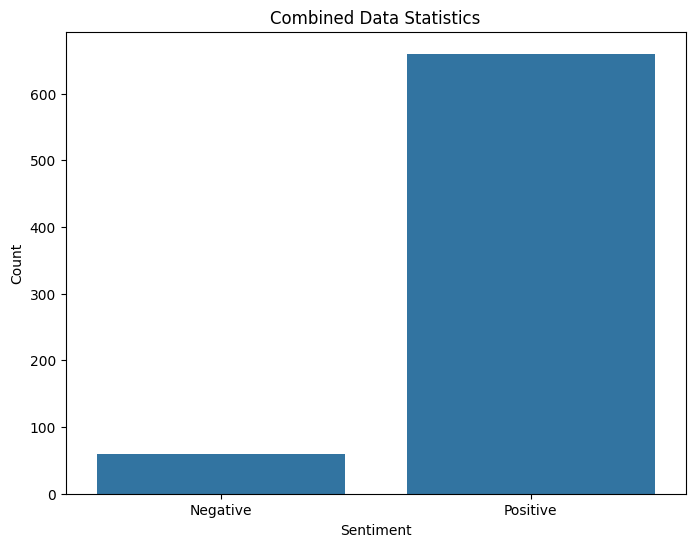

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine testing and training data
combined_data = pd.concat([train_data, test_data])

# Count the number of positive and negative sentiments
sentiment_counts = combined_data['sentiment'].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Combined Data Statistics')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()